<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Setting up a membrane protein in the bilayer](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/15.01-Accounting-for-the-lipid-bilayer.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Running Rosetta in Parellel](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.00-Running-PyRosetta-in-Parellel.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/15.02-Membrane-Protein-ddG-of-mutation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Predicting the ∆∆G of single point mutations

Accurately estimating the thermodynamic cost of a mutation is a building block of protein engineering and design. This task is especially tricky for membrane proteins because the calculations must account for the lipid bilayer. In this tutorial, we will walk through the protocol for estimating the ∆∆G for lipid facing positions using RosettaMP and the _franklin2019_ energy function. 

As an example, we will examine mutations in the integral membrane enzyme PagP. PagP is a beta-barrel protein that transfers a palmitoyl group fron the sn-1 position of a glycerophospholipid to the endotoxin of lipopolysacharide (LPS). The enzyme provides bacterial resistance to host immune defenses such as antimicrobial pepetides (Guo et al. 1998; Kawasaki et al. 2004). Recently, Marx & Fleming measured the energetic cost of making mutations at the V111 position on PagP (Marx & Fleming, 2017). Here, we will perform the same set of mutations with Rosetta and compare with the experimental values. 

## Objectives
 - Setup a protein in an implicit lipid bilayer
 - Compute the ∆∆G of mutation
 - Analyze contributions to the change in stability
 - Visualize the model in PyMOL

## PyRosetta Initialization & Setup

The first step is to initialize PyRosetta and load the protein of interest. In this tutorial, we will use PagP (PDB 3GP6). The starting structure is from the Orientations of Proteins in Membranes database (https://opm.phar.umich.edu/) which provides spatial arrangements of membrane proteins in the lipid bilayer. 

In [ ]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

In [1]:
from pyrosetta import *
init( extra_options="-mp:lipids:has_pore false")

PyRosetta-4 2020 [Rosetta PyRosetta4.MinSizeRel.python37.mac 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python37.mac r242 2020.02+release.22ef835b4a2 22ef835b4a2647af94fcd6421a85720f07eddf12 http://www.pyrosetta.org 2020-01-05T17:31:56
core.init: command: PyRosetta -ex1 -ex2aro -mp:lipids:has_pore false -database /Users/ralford/Applications/env/lib/python3.7/site-packages/pyrosetta-2020.2+release.22ef835b4a2-py3.7-macosx-10.14-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1900191457 seed_offset=0 real_seed=1900191457
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1900191457 RG_type=mt19937


Make sure you are in the right directory for accessing the `.pdb` files:

`cd google_drive/My\ Drive/student-notebooks/`

In [ ]:
#cd google_drive/My\ Drive/student-notebooks/

In [2]:
pose = pose_from_pdb( "inputs/3gp6_A.pdb")

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 980 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.42549 seconds.
core.import_pose.import_pose: File 'inputs/3gp6_A.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  CD  in residue 12 A.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  OE1 in residue 12 A.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  OE2 in residue 12 A.  Pass flag -ignore_zero_occupancy false to change this behavior
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CG  on residue GLU 5
core.conformation.Conformation: [ WARNING ] missing heavyatom:  CD  on residue GLU 5
core.conformation.Conformation: [ W

core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Users/ralford/Applications/env/lib/python3.7/site-packages/pyrosetta-2020.2+release.22ef835b4a2-py3.7-macosx-10.14-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Users/ralford/Applications/env/lib/python3.7/site-packages/pyrosetta-2020.2+release.22ef835b4a2-py3.7-macosx-10.14-x86_64.egg/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.408346 seconds to load from binary
core.pack.pack_rotamers: built 115 rotamers at 9 positions.
core.pack.interaction_graph.interaction_graph_fa

Then, initialize the protein in the membrane using `AddMembraneMover.` Here, the protein is already oriented in the bilayer so we can estimate the transmembrane spans from the structure and orientation. Thus, we use the `from_structure` option to initialize the spanning topology. 

In [3]:
from pyrosetta.rosetta.protocols.membrane import *
add_memb = AddMembraneMover("from_structure")
add_memb.apply(pose)

protocols.membrane.AddMembraneMover: =====================================================================
protocols.membrane.AddMembraneMover: ||           WELCOME TO THE WORLD OF MEMBRANE PROTEINS...          ||
protocols.membrane.AddMembraneMover: =====================================================================
protocols.membrane.AddMembraneMover: No membrane residue was found
protocols.membrane.AddMembraneMover: Adding a new membrane residue to the pose
protocols.membrane.AddMembraneMover: Adding a membrane residue representing the position of the membrane after residue 155
core.chemical.GlobalResidueTypeSet: Loading (but possibly not actually using) 'MEM' from the PDB components dictionary for residue type 'pdb_MEM'
protocols.membrane.AddMembraneMover:    Edge   	   Jump     Jump #
          	0156--0001  001
0001--0155
protocols.DsspMover: LLHHHHHHHHHHHHHHHHHLLLEEEEEEEEEEEELLLLLLLLLLEEEEEEEEELLLLLEEEEEEEEEELLLLLEEEEEEEEEEEEELLLLLLLEEEEEEEEEEEEELHHHLLLEEEEEEEEEEEEELLEEEEEEEELL

core.conformation.membrane.SpanningTopology: Span 2: start: 45, end: 53 orientation: 1
core.conformation.membrane.SpanningTopology: Span 3: start: 59, end: 68 orientation: 1
core.conformation.membrane.SpanningTopology: Span 4: start: 74, end: 86 orientation: 1
core.conformation.membrane.SpanningTopology: Span 5: start: 94, end: 106 orientation: 1
core.conformation.membrane.SpanningTopology: Span 6: start: 114, end: 126 orientation: 1
core.conformation.membrane.SpanningTopology: Span 7: start: 129, end: 136 orientation: 1
core.conformation.membrane.SpanningTopology: Span 8: start: 145, end: 154 orientation: 1
protocols.membrane.AddMembraneMover: Implicit Lipid Information
protocols.membrane.AddMembraneMover: Information about the Lipid Composition:
protocols.membrane.AddMembraneMover: Water thickness: 15.351
protocols.membrane.AddMembraneMover: Change in water density: 0.343
protocols.membrane.AddMembraneMover: Transformed water thickness: 199.57
protocols.membrane.AddMembraneMover: Lip

## ∆∆G of mutation calculations

Next, we will compute the ∆∆G for several point mutations in PagP. In the Marx & Fleming experiment, position V111 was first mutated to alanine. Therefore, we will create this variant first. We will use the `mutate_residue` function from the `predict_ddG` PyRosetta module included in this package. In this tutorial, we will use a repack radius of 8.0 Å. 

An important note - Pyrosetta residue numbering may differ from the PDB numbering because PyRosetta requires continuous numbering for calculations. Here, the PyRosetta residue number for V111 is 104. 

In [4]:
from additional_scripts import predict_ddG
# Create a franklin2019 energy function
sfxn = create_score_function("franklin2019")
# Repack and score the native conformation
reference_pose = predict_ddG.mutate_residue(pose, 104, "A", 8.0, sfxn)

protocols.membrane.scoring.FaWaterToBilayerEnergy: Reading fa_water_to_bilayer parameters from the database
basic.io.database: Database file opened: membrane/memb_fa_params_2019.txt
core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph


To demonstrate the ΔΔG calculation, we will now compute the energetic cost
of mutating alanine to tryptophan.

In [5]:
# Score the alanine reference pose
score_A111 = sfxn.score(reference_pose)
# Repack and score the L111 conformation
pose_W111 = predict_ddG.mutate_residue(pose, 104, "W", 8.0, sfxn)
score_W111 = sfxn.score(pose_W111)
# Compute the ddG of mutation as mutant_score - native_score (final-initial
ddG = score_W111 - score_A111
print(ddG)

core.pack.pack_rotamers: built 54 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
-1.6647217086966464


The ΔΔG for mutating alanine to tryptophan at position 111 is -1.84 Rosetta Energy Units (REU). A
Rosetta Energy Unit is an arbitrary unit for the Rosetta energy function. Next, we would like to
compute the ΔΔG for mutating alanine to all 19 canonical amino acids. To do so, we will generalize
the code above into a function for easy calculations of multiple single point mutations.

In [6]:
def compute_ddG(pose, native_res, site_no, mutant_res, sfxn): 
    """A function for computing the ddG of single point mutations
    
    Example: 
        $ compute_ddG(pose, "V", 49, "A", sfxn)
        
    Arguments: 
        - pose = Object containing the coordinates for the biomolecular system
        - native_res = Native amino acid
        - site_no = Host site amino acid position
        - mutant_res = Mutant amino acid
        = sfxn = Score function object
    """
    
    repacked_native = predict_ddG.mutate_residue(pose, site_no, native_res, 8.0, sfxn)
    native_score = sfxn.score(repacked_native)
    repacked_mutant = predict_ddG.mutate_residue(pose, site_no, mutant_res, 8.0, sfxn)
    mutant_score = sfxn.score(repacked_mutant)
    ddG = mutant_score - native_score
    return ddG

Now, we will write a loop that computes the ΔΔG for all canonical amino acids and store the results
in a python dictionary.

In [7]:
# List of canonical amino acid one-letter codes
amino_acids = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
# Initialize an empty dictionary to store the data
ddG_data = {}
# Loop through all amino acids
for aa in amino_acids:
    ddG = compute_ddG(reference_pose, 'A', 104, aa, sfxn)
    ddG_data[ aa ] = ddG

core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: built 58 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: built 59 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
core.pack.pack_rotamers: built 50 rotamers at 11 positions.
core.pack.interaction_graph.inte

The next step is to compare the ΔΔG predictions to the experimentally measured values. The experimental data for Marx & Fleming are located in `inputs` in a file called `PagP_Marx_Fleming_set.dat`. We will parse the file and then import these values into a |dictionary.

In [8]:
# Read contents of file into a list (file format is space delimited)
with open( 'inputs/PagP_Marx_Fleming_set.dat', 'rt' ) as f:
    data = f.readlines()
    data = [ x.strip() for x in data ]
    data = [ x.split(' ') for x in data ]

# Convert the list into a dictionary
exp_ddG_data = {}
for i in range(1, len(data)):
    exp_ddG_data[ data[i][2] ] = float(data[i][3])

We now convert the dictionary format to numpy arrays that are compatible with analysis. Here, we
will compute the correlation coefficient and make a scatterplot of the experimentally measured vs.
predicted values.

In [9]:
import numpy as np
mutations = np.asarray( ddG_data.keys() )
ddG_values = np.asarray( list(ddG_data.values()) )
exp_values = np.asarray( list(exp_ddG_data.values()) )

# Compute the correlation coefficient
corr = np.corrcoef( exp_values, ddG_values )
print(corr[0,1])

0.3590768320982386


We initially find that the correlation coefficient is low (0.376). We will want to find any outliers in the dataset that are lowering this value.

In [10]:
def find_outliers(x):
    upper_quartile = np.percentile(x, 75)
    lower_quartile = np.percentile(x, 25)
    IQR = (upper_quartile - lower_quartile)
    quartile_set = (lower_quartile - IQR, upper_quartile + IQR)
    for y in x.tolist():
        if (y < quartile_set[0]) or (y > quartile_set[1]):
            print(y)
find_outliers(ddG_values)

167.71057239138239


Here, the ΔΔG value for proline is an outlier. We will investigate this more later. For now, we will remove it from the set and then recompute the correlation coefficient.

In [11]:
# Proline is the 13th, amino acid of 20
exp_data_no_P = []
pred_data_no_P = []
for i in range(0, 20):
    if ( i != 12 ):
        exp_data_no_P.append( list(exp_ddG_data.values())[i] )
        pred_data_no_P.append( list(ddG_data.values())[i] )

exp_data_no_P = np.asarray( exp_data_no_P )
pred_data_no_P = np.asarray( pred_data_no_P )
corr = np.corrcoef( exp_data_no_P, pred_data_no_P )
print(corr[0,1])

0.6720890940120559


The new value of R = 0.692 is much more encouraging! Next, we will visualized the predicted vs. experimentally measured values with a scatterplot.

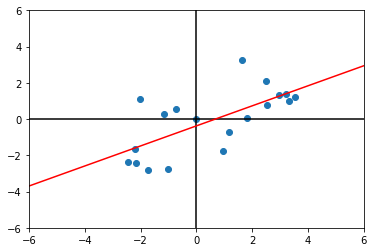

In [12]:
import matplotlib.pyplot as plt
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle="-")
plt.ylim([-6,6])
plt.xlim([-6,6])

# compute the best fit line
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(exp_data_no_P, pred_data_no_P, 1)
x = np.linspace(-6, 6, num=50)
plt.plot(x, b + m * x, color='r', linestyle='-')

# plot the data
plt.scatter(exp_data_no_P, pred_data_no_P)

Finally, we would like to use the models to learn why some mutations stabilized PagP, whereas other side chains did not. Of course, we need a metric for identifying the most confident predictions, especially since the correlation coefficient is not perfect. To do so, we will compute the residuals from the line of best fit and set an empirical cutoff of 1.5 REU.

[ 0.   -0.72  2.49  1.18 -2.44  1.64  3.32 -2.17  3.54 -2.01 -1.15  2.95
  2.54  3.22  1.83  0.95 -1.75 -2.21 -1.02]


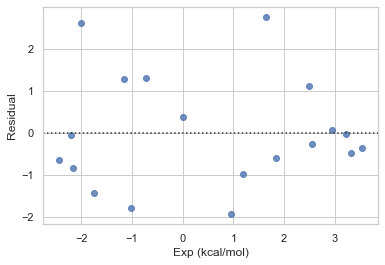

In [13]:
import seaborn as sns
sns.set(style="whitegrid")
resid = sns.residplot(exp_data_no_P, pred_data_no_P, color="b")
resid.set_ylabel("Residual")
resid.set_xlabel("Exp (kcal/mol)")
print(exp_data_no_P)

Here, we find five ∆∆G values that are predicted outside of the cutoff: Glycine, Leucine, Valine, Tryptophan, and Threonine. Next, we will use this information to hypothesize a mechanism for a reasonable prediction (lysine) and rationalize incorrect predictions for proline and leucine. The first step is to quantify which energy components make the largest contribution to the overall ∆∆G of mutation. To do so, we will write a function that can extrapolate this information from the energy function. 

In [14]:
# Store models of mutated PagP proteins
mutant_tyr = predict_ddG.mutate_residue(pose, 104, "Y", 8.0, sfxn)
mutant_lys = predict_ddG.mutate_residue(pose, 104, "K", 8.0, sfxn)
mutant_leu = predict_ddG.mutate_residue(pose, 104, "L", 8.0, sfxn)

core.pack.pack_rotamers: built 53 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
core.pack.pack_rotamers: built 71 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph
core.pack.pack_rotamers: built 52 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating PDInteractionGraph


In [21]:
def get_energy_components( native_pose, mutated_pose, sfxn): 

    # Extract & parse scores
    tmp_native = native_pose.energies().total_energies().weighted_string_of( sfxn.weights() )
    tmp_mutant = mutated_pose.energies().total_energies().weighted_string_of( sfxn.weights() )
    array_native = list(filter( None, tmp_native.split(' ') ))
    array_mutant = list(filter( None, tmp_mutant.split(' ') ))

    # Pull out only the scores from these arrays
    native_scores = []
    for i in range( len(array_native) ): 
        if ( i % 2 != 0 ): 
            native_scores.append( float( array_native[i] ) )

    mutant_scores = []
    for i in range( len(array_mutant) ): 
        if ( i % 2 != 0 ): 
            mutant_scores.append( float( array_mutant[i] ) )

    # Calculate ddG of individual components
    ddGs = []
    for i in range( len( mutant_scores ) ): 
        ddG_component = mutant_scores[i] - native_scores[i]
        ddGs.append( round( ddG_component, 3 ) )

    # Get labels
    labels = []
    for i in range( len(array_native) ): 
        if ( i % 2 == 0 ): 
            labels.append( array_native[i].translate(':').strip(":") )

    return labels, ddGs

# Compute the ddG breakdown
labels, tyr_ddGs = get_energy_components( reference_pose, mutant_tyr, sfxn )
labels, lys_ddGs = get_energy_components( reference_pose, mutant_lys, sfxn )
labels, leu_ddGs = get_energy_components( reference_pose, mutant_leu, sfxn )
print(labels)

['fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep', 'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'ref', 'fa_water_to_bilayer', 'rama_prepro']


Next, we will make a bar graph to visualize the contributions of each energy component for the ddG of these three single point mutations.

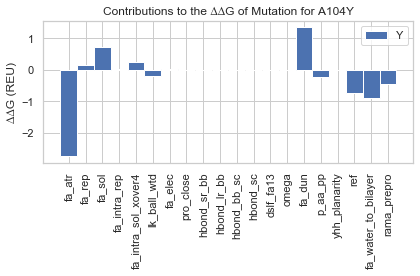

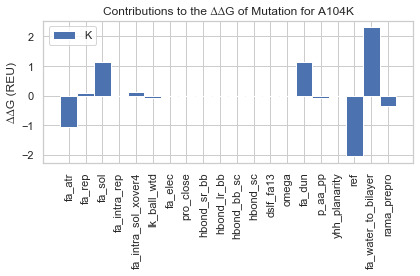

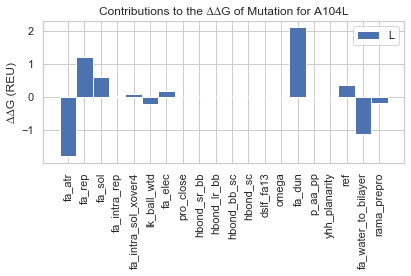

In [16]:
x = np.arange(len(labels))  
width = 1  # the width of the bars

# Plot for tyrosine
fig, ax = plt.subplots()
rects1 = ax.bar(x, tyr_ddGs, width, label='Y')
ax.set_ylabel('∆∆G (REU)')
ax.set_title('Contributions to the ∆∆G of Mutation for A104Y')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()
fig.tight_layout()

# Plot for lysine
fig, ax = plt.subplots()
rects2 = ax.bar(x, lys_ddGs, width, label='K')
ax.set_ylabel('∆∆G (REU)')
ax.set_title('Contributions to the ∆∆G of Mutation for A104K')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()
fig.tight_layout()

# Plot for lysine
fig, ax = plt.subplots()
rects3 = ax.bar(x, leu_ddGs, width, label='L' )
ax.set_ylabel('∆∆G (REU)')
ax.set_title('Contributions to the ∆∆G of Mutation for A104L')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()
fig.tight_layout()

Finally, we will export the model files so that we can visualize them in PyMOL. 

In [17]:
reference_pose.dump_pdb( "PagP_ala_ref.pdb" )
mutant_tyr.dump_pdb( "PagP_A104Y.pdb" )
mutant_lys.dump_pdb( "PagP_A104K.pdb" )
mutant_leu.dump_pdb( "PagP_A104L.pdb" )

True

#### TODO List
 - make notes about lipid composiiton above
 - view in pymol
 - hypothesize mechanisms
 - add notes about what to do without experimental information
 - break into sections as prescribed above

<!--NAVIGATION-->
< [Setting up a membrane protein in the bilayer](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/15.01-Accounting-for-the-lipid-bilayer.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Running Rosetta in Parellel](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.00-Running-PyRosetta-in-Parellel.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/15.02-Membrane-Protein-ddG-of-mutation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>